## An example of quantum multiprogramming

In this notebook we show an example where we can execute two circuits of 10 qubits each parallely on the same hardware. This increases the throughput of the hardware, and helps reduce the overall time required. We shall consider two random circuits for this notebook, and show methods for obtaining both the expectation value of some observable, as well as the probability distribution.

In [13]:
from qiskit.circuit.random import random_circuit

qc1 = random_circuit(4, depth=4, max_operands=2, seed=0)
qc2 = random_circuit(4, depth=4, max_operands=2, seed=1)

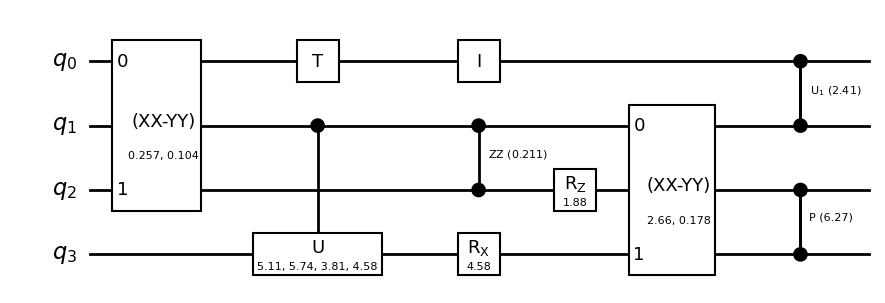

In [14]:
qc1.draw('mpl', style='bw', fold=-1)

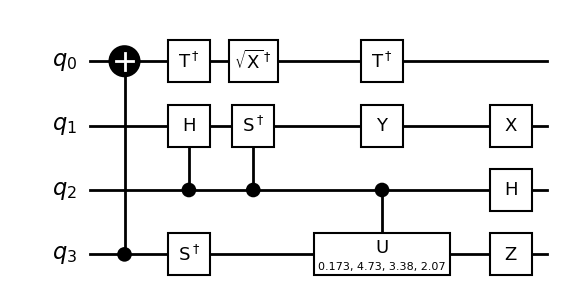

In [15]:
qc2.draw('mpl', style='bw', fold=-1)

#### Combine the two circuits into a single circuit

Now, we combine the two circuits into a single circuit.

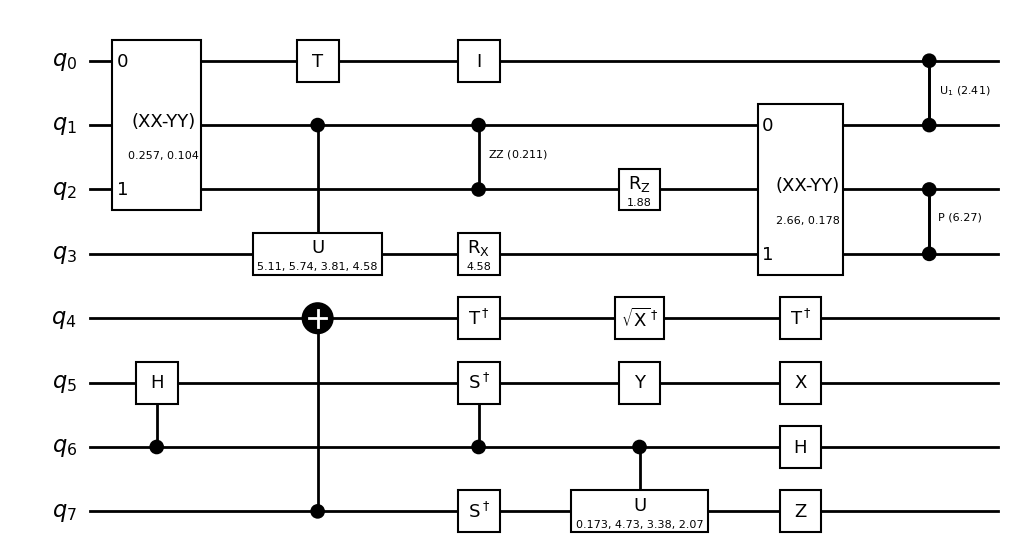

In [20]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(qc1.num_qubits + qc2.num_qubits)
qc.compose(qc1, range(qc1.num_qubits), inplace=True)
qc.compose(qc2, range(qc1.num_qubits, qc1.num_qubits + qc2.num_qubits), inplace=True)
qc.draw('mpl', style='bw', fold=-1)

#### Transpile the circuit

In [17]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
backend = FakeSherbrooke()

Let us first select a layout for each circuit. Note that this in not mandatory for transpiling a circuit. However, without specifying the layout, the transpiler with transpile the qubits as adjacently as possible - hence there will be scope of crosstalk coming from two adjacent qubits from two different circuits.

For more information on finding the optimal layout in such a scenario, refer to <a href="https://arxiv.org/abs/2407.08930">this paper</a>. For this notebook, we arbitrarily select two layouts for the two circuits.

In [21]:
layout1 = [0,1,2,3]
layout2 = [113,114,115,116]

layout = layout1 + layout2

In [23]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=3, backend=backend, initial_layout=layout)
trans_qc = pm.run(qc)

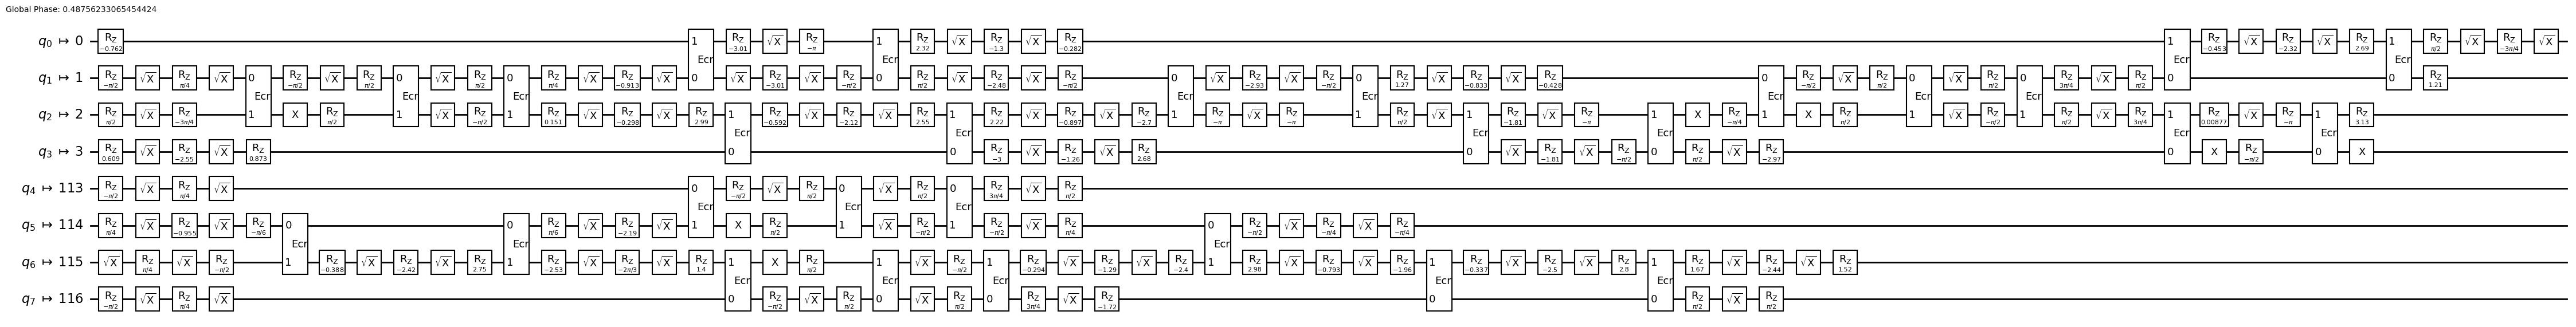

In [24]:
trans_qc.draw('mpl', style='bw', fold=-1, idle_wires=False)

### Obtaining the probability distribution

In [25]:
if trans_qc.num_clbits == 0:
    trans_qc.measure_active()

In [27]:
from qiskit_ibm_runtime import SamplerV2
sampler = SamplerV2(backend=backend)

In [29]:
pub = (trans_qc)
job = sampler.run([pub])
result = job.result()[0]

In [32]:
counts = result.data.measure.get_counts()

The `counts` dictionary now contains the combined counts of the two circuits. We need to `marginalize` for each circuit.

In [39]:
from qiskit.result import marginal_counts

counts1 = marginal_counts(counts, range(qc1.num_qubits))
counts2 = marginal_counts(counts, range(qc1.num_qubits, qc1.num_qubits+qc2.num_qubits))

#### Validation

Now we execute the two circuits separately to validate the obtained outcome. For this, we need to separately transpile the two circuits on their corresponding layouts and execute them.

In [35]:
pm1 = generate_preset_pass_manager(optimization_level=3, backend=backend, initial_layout=layout1)
trans_qc1 = pm1.run(qc1)

pm2 = generate_preset_pass_manager(optimization_level=3, backend=backend, initial_layout=layout2)
trans_qc2 = pm2.run(qc2)

In [36]:
if trans_qc1.num_clbits == 0:
    trans_qc1.measure_active()
if trans_qc2.num_clbits == 0:
    trans_qc2.measure_active()

In [37]:
pubs = [(trans_qc1),(trans_qc2)]
job = sampler.run(pubs)

result0 = job.result()[0]
result1 = job.result()[1]

In [40]:
counts_single1 = result0.data.measure.get_counts()
counts_single2 = result1.data.measure.get_counts()

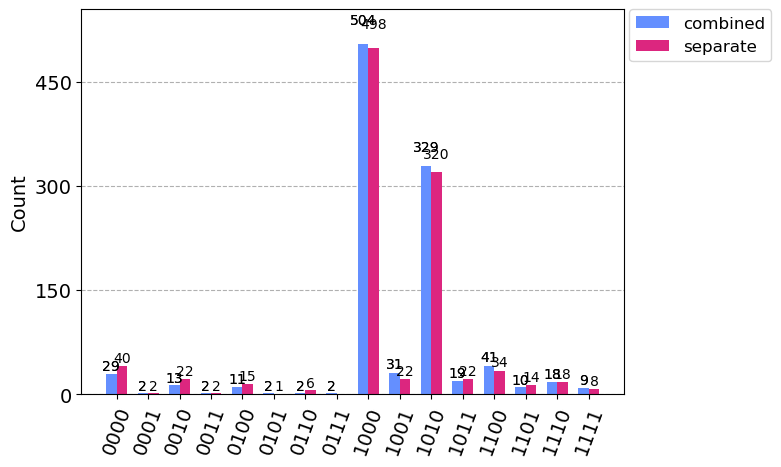

In [42]:
from qiskit.visualization import plot_histogram

plot_histogram([counts1, counts_single1], legend=['combined', 'separate'])

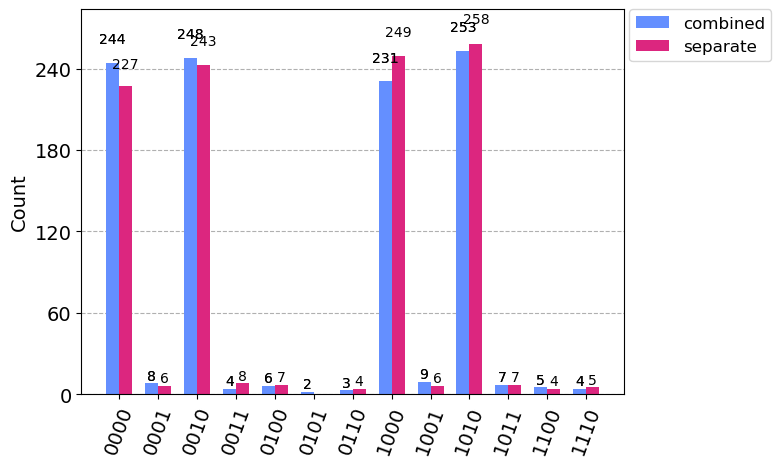

In [43]:
from qiskit.visualization import plot_histogram

plot_histogram([counts2, counts_single2], legend=['combined', 'separate'])